/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 - 9s - 2s/step - loss: 0.2251 - val_loss: 0.0152
Epoch 2/50
5/5 - 0s - 40ms/step - loss: 0.0714 - val_loss: 0.1229
Epoch 3/50
5/5 - 0s - 40ms/step - loss: 0.0795 - val_loss: 0.0265
Epoch 4/50
5/5 - 0s - 63ms/step - loss: 0.0830 - val_loss: 0.0131
Epoch 5/50
5/5 - 0s - 52ms/step - loss: 0.0825 - val_loss: 0.0177
Epoch 6/50
5/5 - 0s - 50ms/step - loss: 0.0690 - val_loss: 0.0300
Epoch 7/50
5/5 - 0s - 61ms/step - loss: 0.0644 - val_loss: 0.0342
Epoch 8/50
5/5 - 0s - 87ms/step - loss: 0.0664 - val_loss: 0.0358
Epoch 9/50
5/5 - 0s - 69ms/step - loss: 0.0578 - val_loss: 0.0349
Epoch 10/50
5/5 - 0s - 67ms/step - loss: 0.0580 - val_loss: 0.0339
Epoch 11/50
5/5 - 0s - 69ms/step - loss: 0.0537 - val_loss: 0.0342
Epoch 12/50
5/5 - 1s - 126ms/step - loss: 0.0571 - val_loss: 0.0323
Epoch 13/50
5/5 - 0s - 56ms/step - loss: 0.0521 - val_loss: 0.0302
Epoch 14/50
5/5 - 0s - 49ms/step - loss: 0.0502 - val_loss: 0.0240
Epoch 15/50
5/5 - 0s - 53ms/step - loss: 0.0446 - val_loss: 0.0292
Epoch

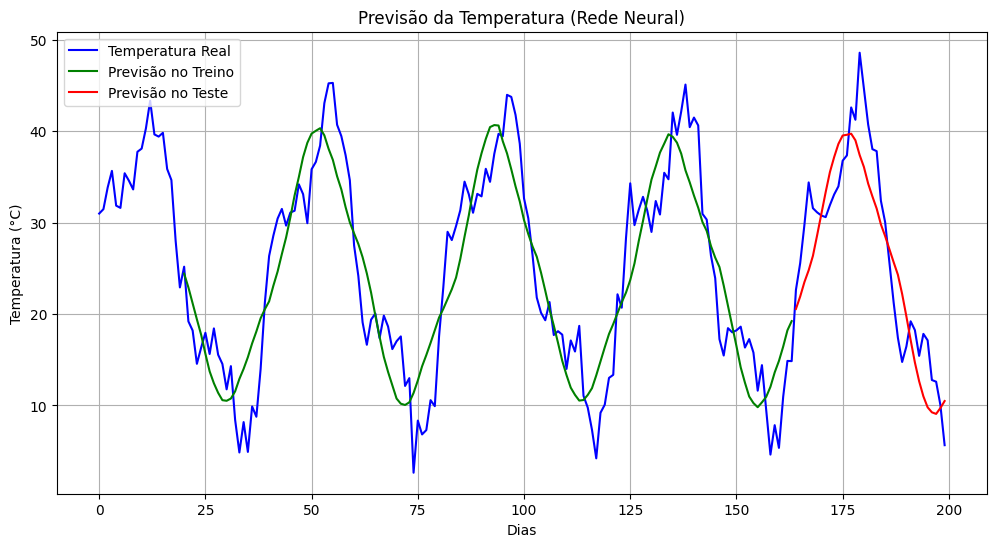

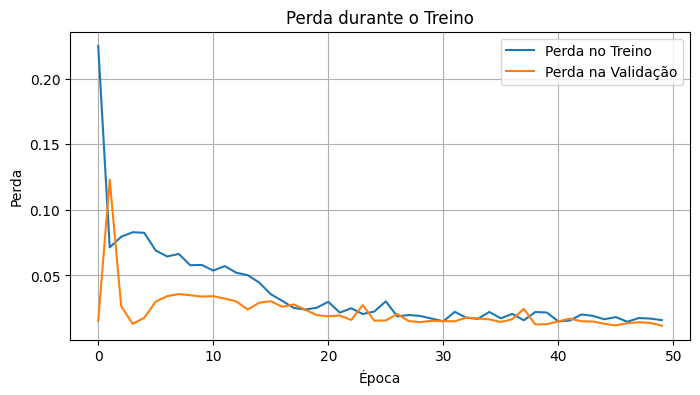

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# Reprodutibilidade
np.random.seed(42)

# Geração de dados (simulados)
tempo = np.linspace(0, 30, 200)
temperatura = (
    np.sin(tempo) * 15
    + np.cos(tempo * 3) * 5
    + 25
    + np.random.normal(0, 2, 200)
)
dados = pd.DataFrame(temperatura, columns=["Temperatura"])

# Pré-processamento: Normalização
escalador = MinMaxScaler(feature_range=(0, 1))
temperatura_escalada = escalador.fit_transform(dados[["Temperatura"]])

# Função para criar janelas temporais
def criar_janelas(dados, tamanho_janela):
    X, y = [], []
    for i in range(len(dados) - tamanho_janela):
        janela = dados[i : (i + tamanho_janela), 0]
        X.append(janela)
        y.append(dados[i + tamanho_janela, 0])
    return np.array(X), np.array(y)

tamanho_janela = 20
X, y = criar_janelas(temperatura_escalada, tamanho_janela)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Divisão treino/teste
tamanho_treino = int(len(X) * 0.8)
X_treino, X_teste = X[0:tamanho_treino], X[tamanho_treino:len(X)]
y_treino, y_teste = y[0:tamanho_treino], y[tamanho_treino:len(y)]


# Construção do modelo LSTM
modelo = keras.Sequential()
modelo.add(
    keras.layers.LSTM(
        50, return_sequences=True, input_shape=(X_treino.shape[1], 1)
    )
)
modelo.add(keras.layers.Dropout(0.2))
modelo.add(keras.layers.LSTM(50, return_sequences=True))
modelo.add(keras.layers.Dropout(0.2))
modelo.add(keras.layers.LSTM(50))
modelo.add(keras.layers.Dropout(0.2))
modelo.add(keras.layers.Dense(1))
modelo.compile(optimizer="adam", loss="mean_squared_error")

# Treinamento
historico = modelo.fit(
    X_treino,
    y_treino,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=2,
	shuffle = False
)

# Previsões
previsao_treino = modelo.predict(X_treino)
previsao_teste = modelo.predict(X_teste)

# Inversão da normalização
previsao_treino = escalador.inverse_transform(previsao_treino)
y_treino_original = escalador.inverse_transform(y_treino.reshape(-1, 1))
previsao_teste = escalador.inverse_transform(previsao_teste)
y_teste_original = escalador.inverse_transform(y_teste.reshape(-1, 1))

# Visualização
plt.figure(figsize=(12, 6))
plt.plot(dados["Temperatura"].values, label="Temperatura Real", color="blue")

previsao_treino_plot = np.empty_like(dados["Temperatura"])
previsao_treino_plot[:] = np.nan
previsao_treino_plot[
    tamanho_janela : len(previsao_treino) + tamanho_janela
] = previsao_treino.flatten()
plt.plot(previsao_treino_plot, label="Previsão no Treino", color="green")

previsao_teste_plot = np.empty_like(dados["Temperatura"])
previsao_teste_plot[:] = np.nan
previsao_teste_plot[
    len(previsao_treino) + tamanho_janela : len(dados)
] = previsao_teste.flatten()
plt.plot(previsao_teste_plot, label="Previsão no Teste", color="red")

plt.legend()
plt.title("Previsão da Temperatura (Rede Neural)")
plt.xlabel("Dias")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.show()

# Visualização da perda
plt.figure(figsize=(8, 4))
plt.plot(historico.history['loss'], label='Perda no Treino')
plt.plot(historico.history['val_loss'], label='Perda na Validação')
plt.title('Perda durante o Treino')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()